
# Telco Customer Churn Prediction Using Machine Learning 


# 1. Business Understanding


Problem Statement

Customer attrition (churn) is a significant concern for businesses as it directly impacts revenue and growth. Understanding the factors influencing churn and predicting it accurately can help organizations implement proactive retention strategies.

Goals and Objectives

    Goal: 
Develop a machine learning model to predict customer churn.

    Objectives:
Identify key indicators of churn.
Build a model with high accuracy, precision, and recall.
Provide actionable insights to reduce churn rate.

Hypothesis (Null and Alternative)

    Null Hypothesis (H0): 
There is no significant relationship between payment method and churn.
    Alternative Hypothesis (H1): 
Payment method significantly influence churn rates.

Analytical Questions
1. How do different customer attributes (e.g. demographs) influence churn?
2. Which services (e.g., internet type, contract terms) are associated with higher churn rates?
3. Can payment methods affect customer retention?
4. Is there a correlation between tenure and churn rate?
    

In [96]:
# Connection packages
import os
import pyodbc  
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package

# Data handling
import pandas as pd
import numpy as np
import warnings 

# EDA 

#import ydata_profiling as pp

# Hypothesis testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# from imblearn.over_sampling import SMOTE  # For balancing the dataset
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline as ImbPipeline


# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Computations
import math

# Warnings
warnings.filterwarnings('ignore')


### Server Connection

In [2]:
# Load environment variables from .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file

server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection string

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [ ]:
# Use the connect method of the pyodbc library and pass in the connection string

connection = pyodbc.connect(connection_string)

connection.timeout = 60 

### First Dataset

In [ ]:
# Fetching sql query

query = "SELECT * FROM LP2_Telco_churn_first_3000"

data = pd.read_sql(query, connection)

In [ ]:
data.head()

In [ ]:
# Save dataFrame to CSV

first_3000 = 'LP2_Telco_churn_first_3000.csv'
data.to_csv(first_3000, index=False)

In [ ]:
# Read the CSV file into a DataFrame

first_3000_data = pd.read_csv(first_3000)

In [ ]:
# Display the first few rows of the DataFrame directly

first_3000_data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [ ]:
first_3000_data.shape

(3000, 21)

### Second Dataset

In [ ]:

second_2000_data = pd.read_csv('LP2_Telco-churn-second-2000.csv')
second_2000_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [ ]:
second_2000_data.shape

(2043, 21)

### Concatenate Datasets

In [ ]:
# Concatenate the two datasets

# Concatenate based on customerID column
combined_data = pd.concat([first_3000_data.set_index('customerID'), second_2000_data.set_index('customerID')])

# Reset index to make customerID a regular column again
combined_data.reset_index(inplace=True)

combined_data.shape


In [ ]:
# Save the concatenated datasets into a csv format 

combined_data.to_csv('combined_data.csv', index=False)


In [ ]:
combined_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True



# 2. Data Understanding

## Exploratory Data Analysis

###    1. Understanding The Data

In [2]:
combined_data = pd.read_csv('combined_data.csv')

In [3]:
# Create a copy of the original DataFrame to preserve the original data

combined_eda = combined_data.copy()

In [4]:
combined_eda.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


In [5]:
combined_eda.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


#### Standardize The Columns

In [6]:
#Standardizing the True and False values

# Standardize function

def standardize_values(df, column, true_values, false_values):
    df[column] = df[column].replace(true_values, 'Yes')
    df[column] = df[column].replace(false_values, 'No')

# List of columns to standardize
columns_to_standardize = [
    'Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
]

# Values that represent True/Yes and False/No
true_values = ['True', 'Yes', 'yes', 'true']
false_values = ['False', 'No', 'no', 'false']

# Apply standardization
for column in columns_to_standardize:
    standardize_values(combined_eda, column, true_values, false_values)

# Verify changes
for column in columns_to_standardize:
    print(f"{column}: {combined_eda[column].unique()}")


Churn: ['No' 'Yes' nan]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: [nan 'No' 'Yes' 'No phone service']
OnlineSecurity: ['No' 'Yes' nan 'No internet service']
OnlineBackup: ['Yes' 'No' nan 'No internet service']
DeviceProtection: ['No' 'Yes' nan 'No internet service']
TechSupport: ['No' 'Yes' nan 'No internet service']
StreamingTV: ['No' 'Yes' nan 'No internet service']
StreamingMovies: ['No' 'Yes' nan 'No internet service']
PaperlessBilling: ['Yes' 'No']


#### Identifying Missing Values

In [7]:

# Count NaN values in each column
nan_counts = combined_eda.isna().sum()

# Filter and print columns with NaN values
nan_columns = nan_counts[nan_counts > 0]
print("\nColumns with NaN values and their counts:")
print(nan_columns)


Columns with NaN values and their counts:
MultipleLines       269
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
TotalCharges          5
Churn                 1
dtype: int64


In [8]:
columns = combined_eda.columns

In [9]:
# Unique values in each column
for column in columns:
    print(f'{column}')
    print(f'There are {combined_eda[column].unique().size} unique values')
    print(f'These are {combined_eda[column].unique()}')
    print('=' * 50)

customerID
There are 5043 unique values
These are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
There are 2 unique values
These are ['Female' 'Male']
SeniorCitizen
There are 2 unique values
These are [0 1]
Partner
There are 2 unique values
These are ['Yes' 'No']
Dependents
There are 2 unique values
These are ['No' 'Yes']
tenure
There are 73 unique values
These are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
There are 2 unique values
These are ['No' 'Yes']
MultipleLines
There are 4 unique values
These are [nan 'No' 'Yes' 'No phone service']
InternetService
There are 3 unique values
These are ['DSL' 'Fiber optic' 'No']
OnlineSecurity
There are 4 unique values
These are ['No' 'Yes' nan 'No internet service']
OnlineBackup
There are 4 unique values
These a

In [10]:
combined_eda.shape

(5043, 21)

#### Overview After Standardization

In [11]:
#Overview 

combined_eda.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000381469727,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.1500015258789,Yes
3,7795-CFOCW,Male,0,No,No,45,No,NaN,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.64999389648438,Yes


In [12]:
# Overview 
combined_eda.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [13]:
combined_eda.describe(include = 'all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5043,5043,5043.000000,5043,5043,5043.000000,5043,4774,5043,4392,...,4392,4392,4392,4392,5043,5043,5043,5043.000000,5038,5042
unique,5043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,4870,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,NaN,20.450000762939453,No
freq,1,2559,NaN,2585,3482,NaN,4554,2424,2248,2507,...,2219,2472,2018,1982,2744,2996,1700,NaN,5,3706
mean,NaN,NaN,0.162403,NaN,NaN,32.576641,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.090214,NaN,NaN
std,NaN,NaN,0.368857,NaN,NaN,24.529807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.068133,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.775000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.550003,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.050003,NaN,NaN


In [14]:
combined_eda.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4870
Churn                  2
dtype: int64

#### Checking Duplicates

In [15]:
combined_eda[combined_eda.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


#### Checking Data Types

In [16]:
combined_eda.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### Modify Data Types

In [17]:
combined_eda.TotalCharges = pd.to_numeric(combined_eda.TotalCharges, errors='coerce')
combined_eda.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#### General Overview With Profile Report

In [18]:
'''
# Use pandas_profiling.ProfileReport method

pp.ProfileReport(combined_data)
'''

'\n# Use pandas_profiling.ProfileReport method\n\npp.ProfileReport(combined_data)\n'

####    2.Data Quality Assessment 
#####        a. Checking Missing Values


In [19]:
combined_eda.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

#####        b.Detecting Outliers

In [20]:
# Detection through boxplots

def outlier_check_boxplot(df,numerical_values):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = df, palette = "Blues")
        ax.set_title(column)
    return plt.show()
    plt.tight_layout()

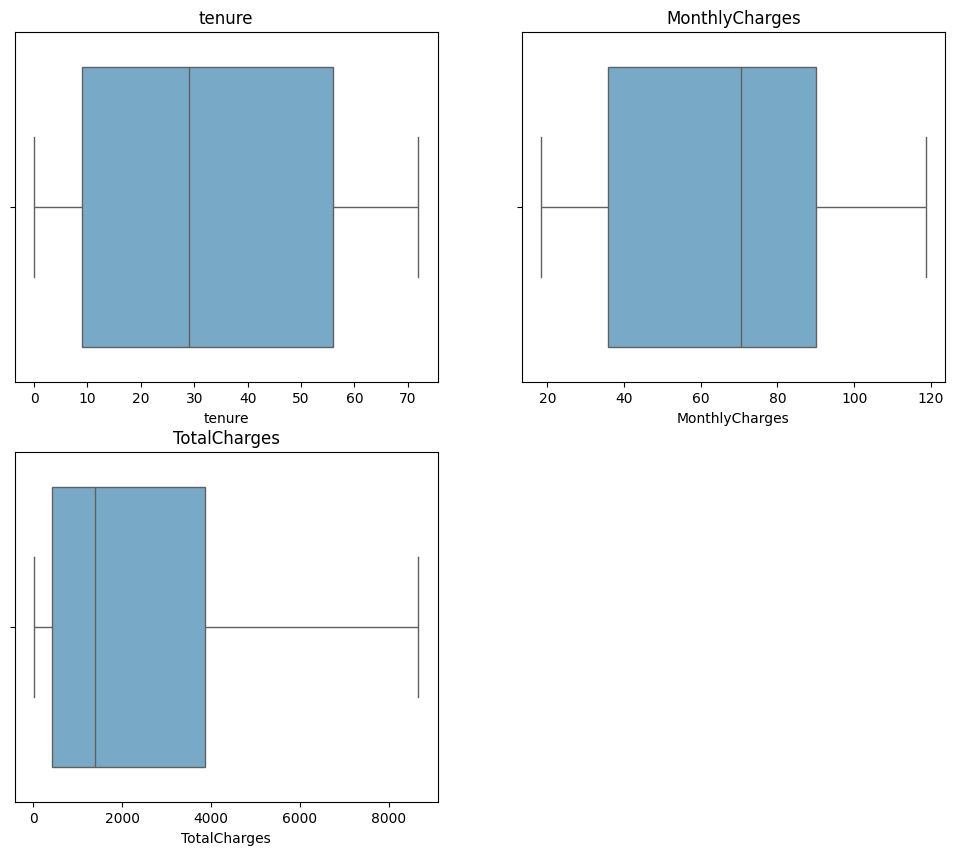

In [21]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
outlier_check_boxplot(combined_eda,numerical_columns)

####    3.Univariate Analysis 

#####        a. Summary Statistics

In [22]:

summary_stats = combined_eda.describe( include = 'all')
summary_stats

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5043,5043,5043.000000,5043,5043,5043.000000,5043,4774,5043,4392,...,4392,4392,4392,4392,5043,5043,5043,5043.000000,5035.000000,5042
unique,5043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,2559,NaN,2585,3482,NaN,4554,2424,2248,2507,...,2219,2472,2018,1982,2744,2996,1700,NaN,NaN,3706
mean,NaN,NaN,0.162403,NaN,NaN,32.576641,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.090214,2302.062861,NaN
std,NaN,NaN,0.368857,NaN,NaN,24.529807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.068133,2269.483576,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,18.799999,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.775000,417.675003,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.550003,1401.150024,NaN
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.050003,3862.000000,NaN


#####        b. Distribution Visualization

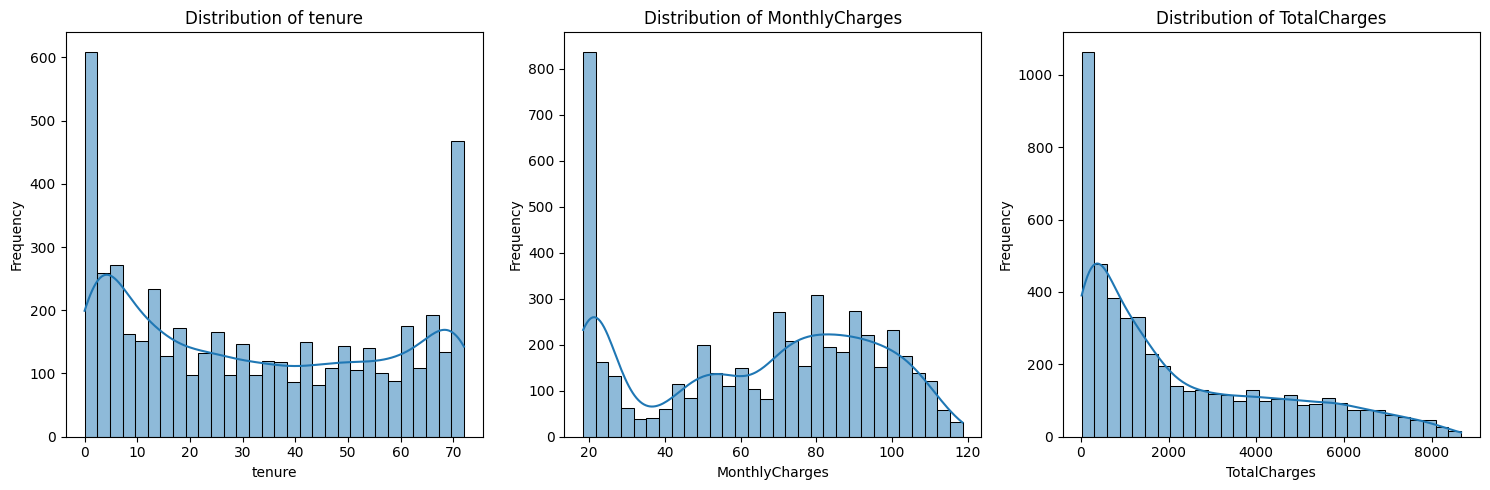

In [23]:
# Separate numerical columns

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Set figure size for individual plots
plt.figure(figsize=(15, 5))

# Histogram for 'tenure'
plt.subplot(1, 3, 1)
sns.histplot(data=combined_eda, x='tenure', kde=True, bins=30)
plt.title('Distribution of tenure')
plt.xlabel('tenure')
plt.ylabel('Frequency')

# Histogram for 'MonthlyCharges'
plt.subplot(1, 3, 2)
sns.histplot(data=combined_eda, x='MonthlyCharges', kde=True, bins=30)
plt.title('Distribution of MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')

# Histogram for 'TotalCharges'
plt.subplot(1, 3, 3)
sns.histplot(data=combined_eda, x='TotalCharges', kde=True, bins=30)
plt.title('Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


 - None of the features above are normally distributed

####    4.Bivariate Analysis 

Customer Service Analysis 

In [24]:
#Make a function to plot categorical data according to target


def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = combined_eda, hue = target, palette="Blues_r")
        ax.set_title(column)
    return plt.show()

In [25]:
print(plt.colormaps()) 

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

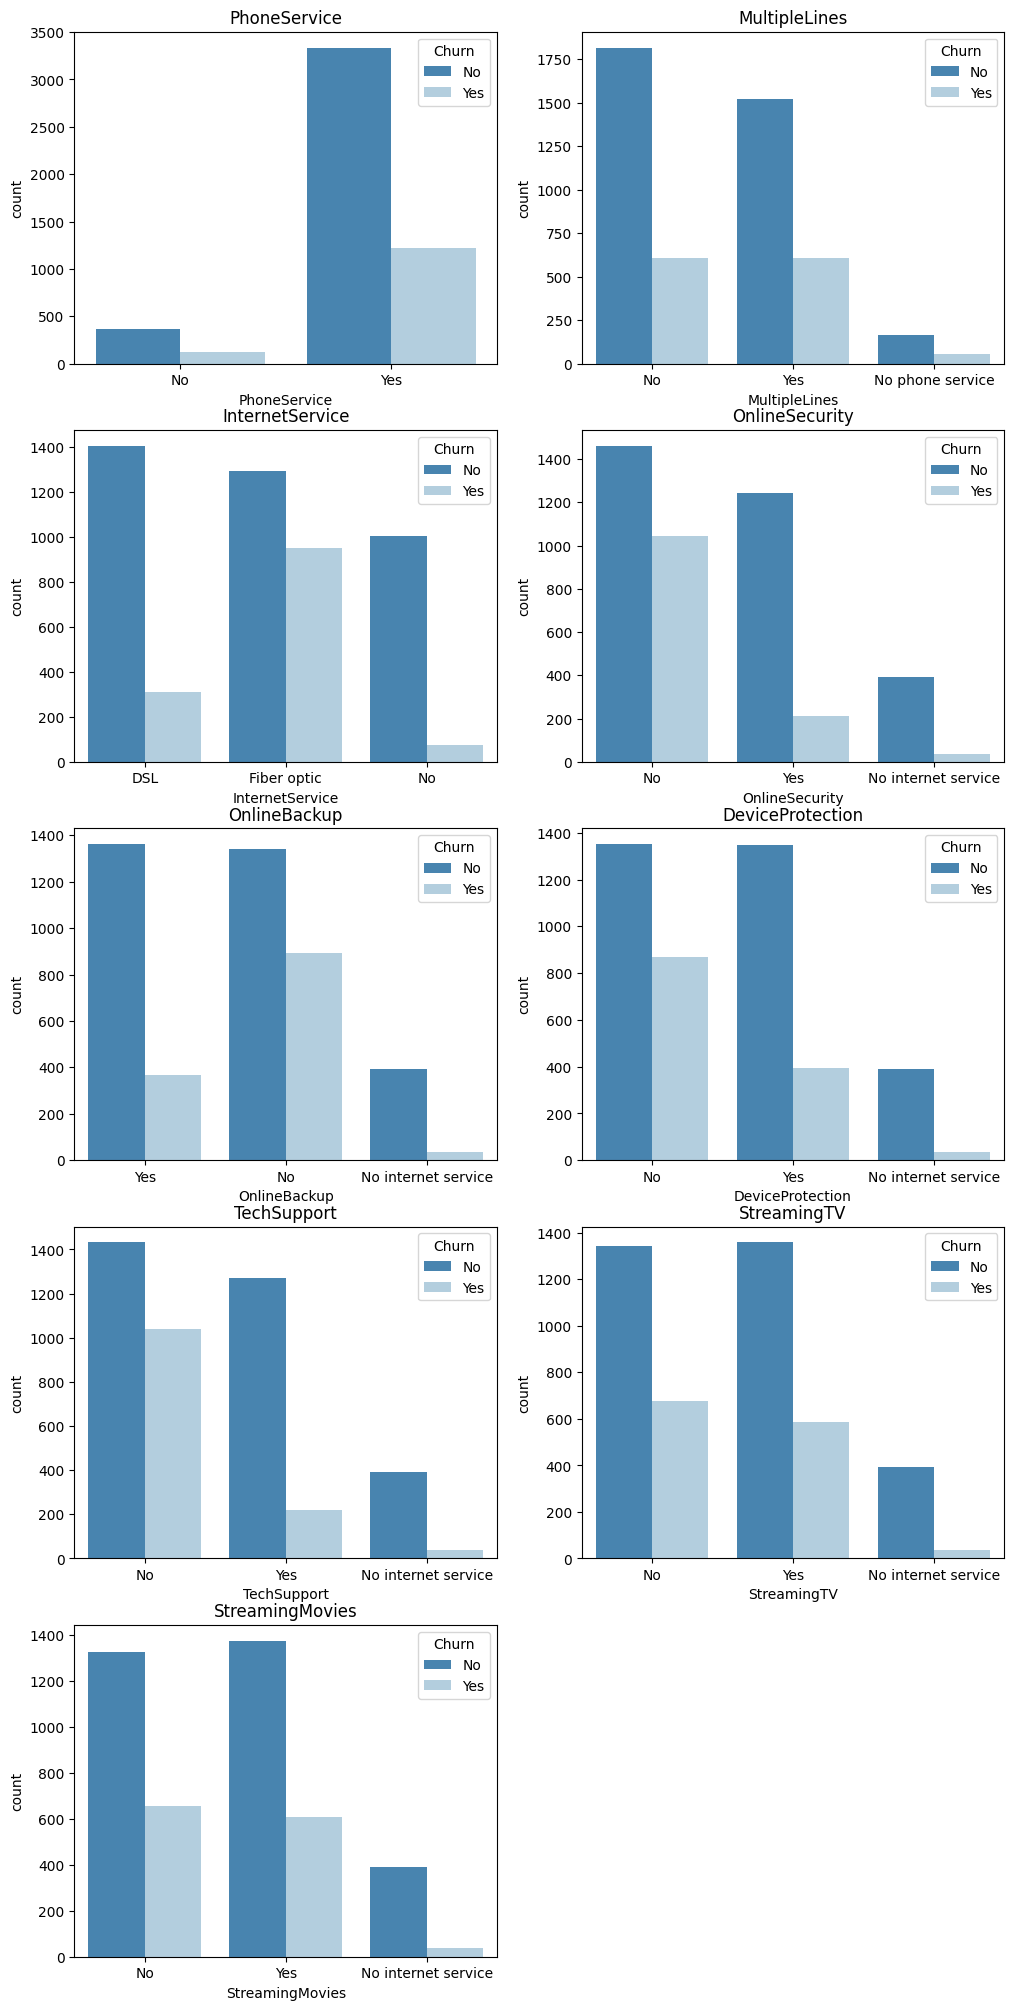

In [26]:
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(combined_eda,customer_services, "Churn")


Customer Account Analysis - Categorical Variables

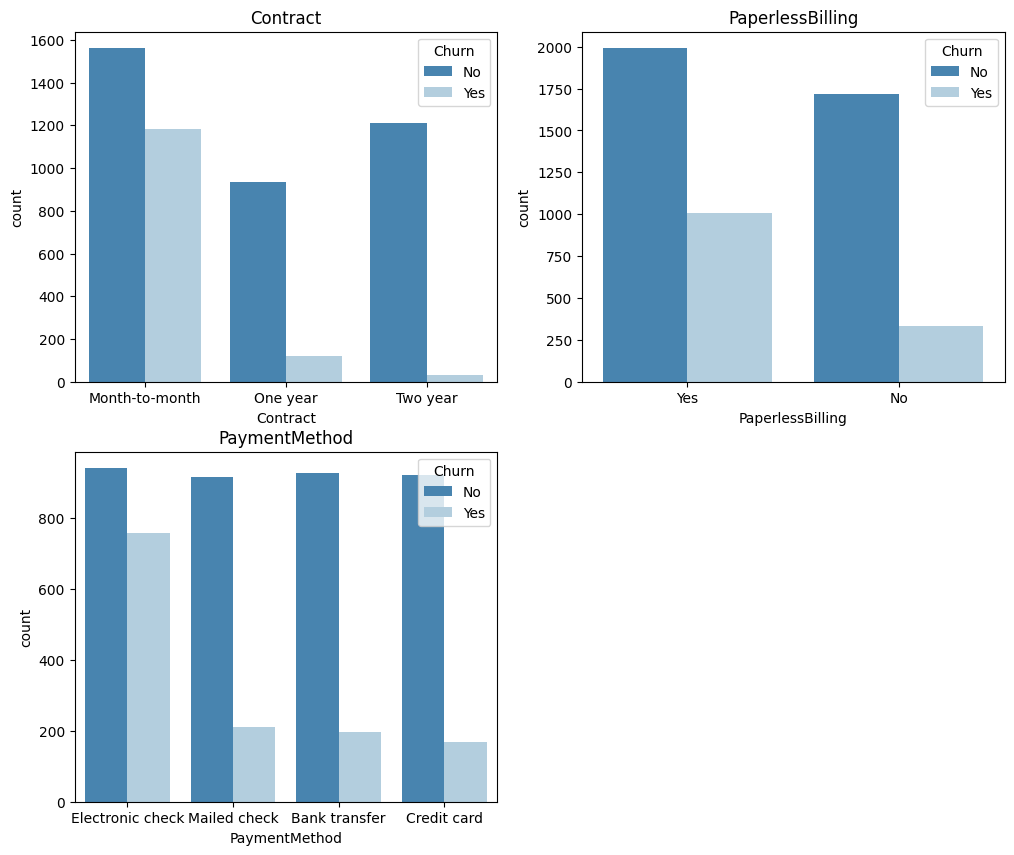

In [27]:
# Delete "automatic" from PaymentMethod for proper visualization

combined_eda["PaymentMethod"] = combined_eda["PaymentMethod"].str.replace(" (automatic)", "", regex=False)

customer_account_cat = ["Contract","PaperlessBilling","PaymentMethod"]
plot_categorical_to_target(combined_eda,customer_account_cat,"Churn")

Customer Demographic Analysis - Categorical Variables

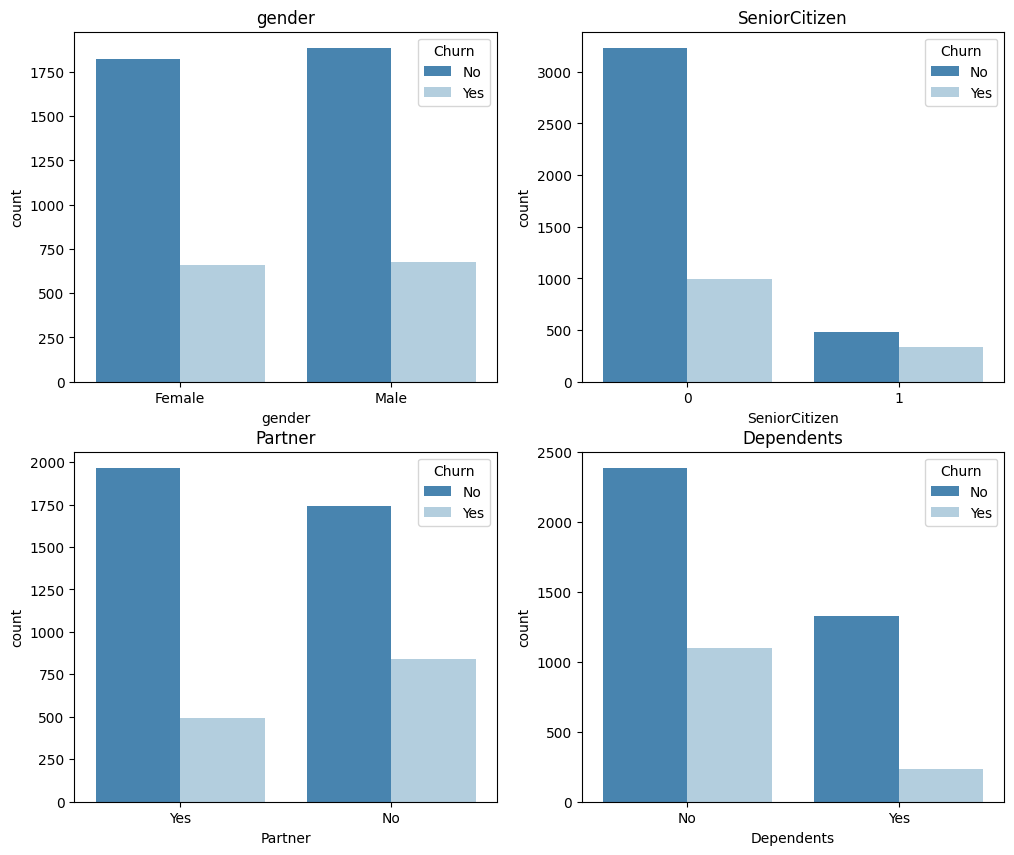

In [28]:
customer_demo_cat = ["gender","SeniorCitizen","Partner","Dependents"]
plot_categorical_to_target(combined_eda,customer_demo_cat,"Churn")

####    5.Multivariate Analysis 


#####        a. Total Charges, Tenure and Churn

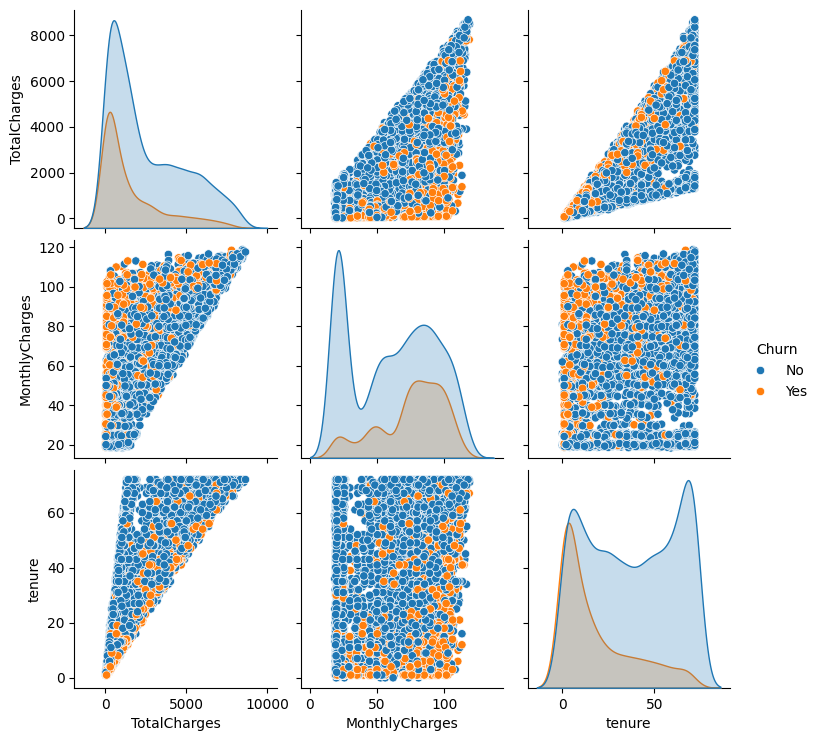

In [29]:
# Pair plot for TotalCharges, MonthlyCharges, Tenure, and Churn

sns.pairplot(combined_eda[['TotalCharges', 'MonthlyCharges', 'tenure', 'Churn']], hue='Churn')
plt.show()


Interpretation:

The plots show pairwise relationships between TotalCharges, MonthlyCharges, and Tenure, colored by churn status.
There is a visible clustering of churned customers in certain areas, particularly those with high charges and low tenure.
High MonthlyCharges and low Tenure are indicative of cost-sensitive customers who are likely to churn.

Correlation Matrix Of Numeric Features

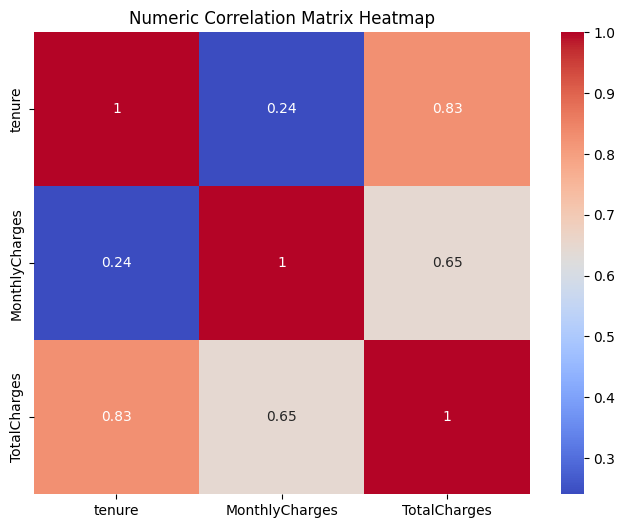

In [30]:
# Select only numeric columns for correlation matrix

numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
sns.heatmap(combined_eda[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Numeric Correlation Matrix Heatmap')
plt.show()

 - From the correlation matrix, there seems to be a strong relationship between tenure and total charges signifying that the longer the tenure the higher the total charges and vice versa 
 - There als seems to be a relative strong relationship between the monthly and total charges indicationg one highly contributes and impacts the other


#### Answering Analytical Questions


1. How do different customer demgraphics (Gender, SeniorCitizen, Partner, Dependents) influence churn?


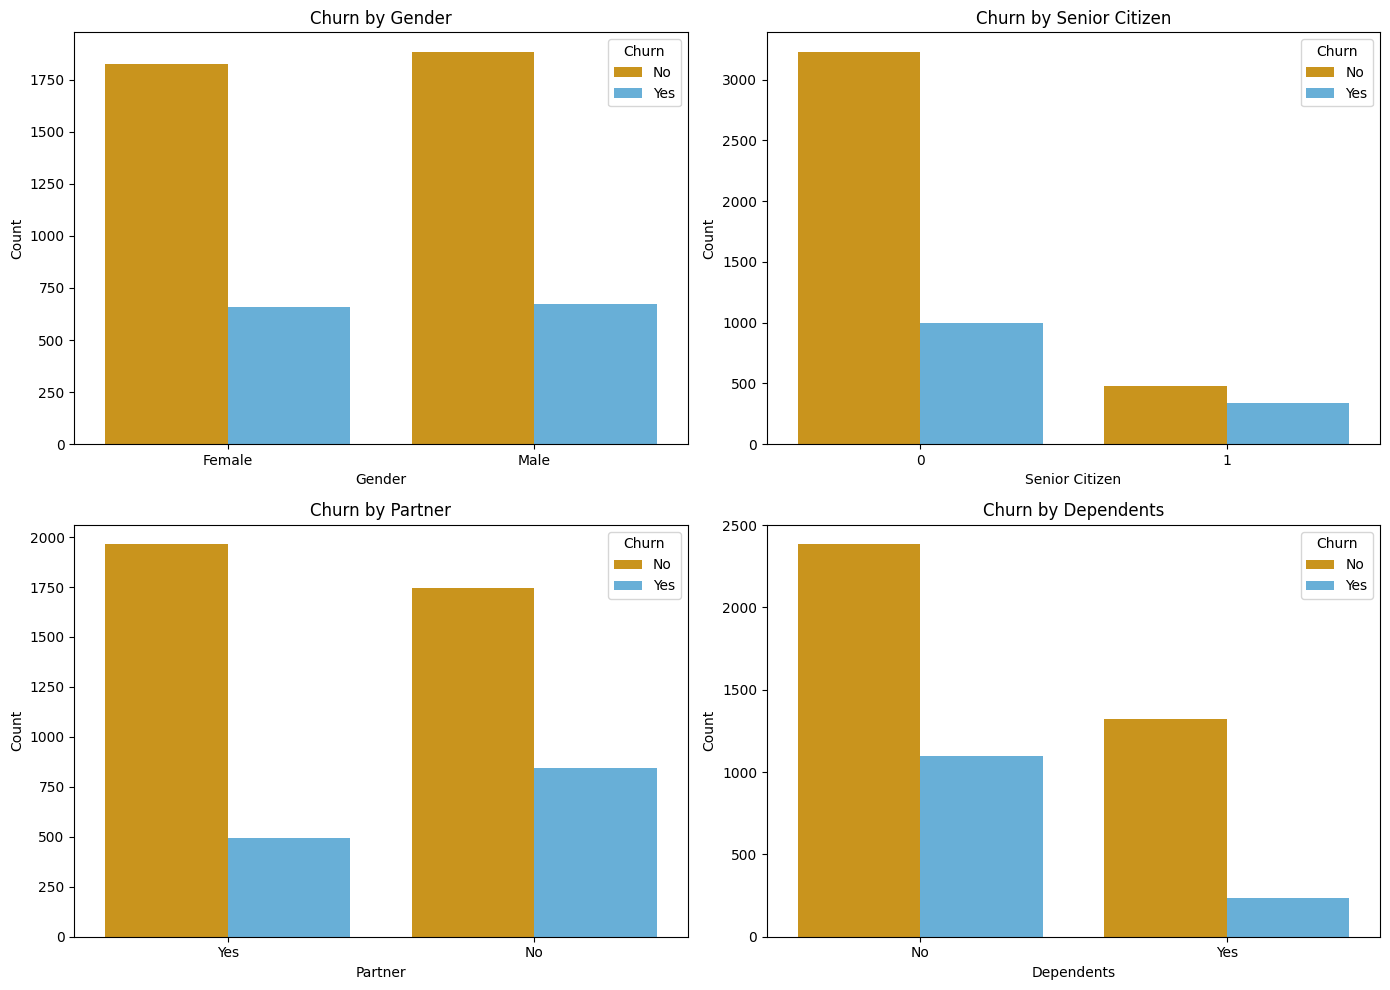

In [31]:
# Setting the color palette for better visualization
color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(14, 10))

# First plot: Churn by Gender
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st position
sns.countplot(x='gender', hue='Churn', data=combined_eda, palette=color_palette)
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Second plot: Churn by Senior Citizen
plt.subplot(2, 2, 2)  # 2nd position
sns.countplot(x='SeniorCitizen', hue='Churn', data=combined_eda, palette=color_palette)
plt.title('Churn by Senior Citizen')
plt.xlabel('Senior Citizen')
plt.ylabel('Count')

# Third plot: Churn by Partner
plt.subplot(2, 2, 3)  # 3rd position
sns.countplot(x='Partner', hue='Churn', data=combined_eda, palette=color_palette)
plt.title('Churn by Partner')
plt.xlabel('Partner')
plt.ylabel('Count')

# Fourth plot: Churn by Dependents
plt.subplot(2, 2, 4)  # 4th position
sns.countplot(x='Dependents', hue='Churn', data=combined_eda, palette=color_palette)
plt.title('Churn by Dependents')
plt.xlabel('Dependents')
plt.ylabel('Count')

# Make sure everything fits nicely
plt.tight_layout()

plt.show()

-Senior citizen dockets seems to have a significantly highy difference showing that young citizens remore likely to churn as compared to senior citizens
- When it comes to partners, those with patners are less likely to churn unlike those that are without patners
- With dependants, those without dependants have a higher churn count vis a vis those with dependants 
- Gender doesn't have to have much significnce as the difference is minimal between the male and female gender

2. Which services (PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) are associated with higher churn rates?

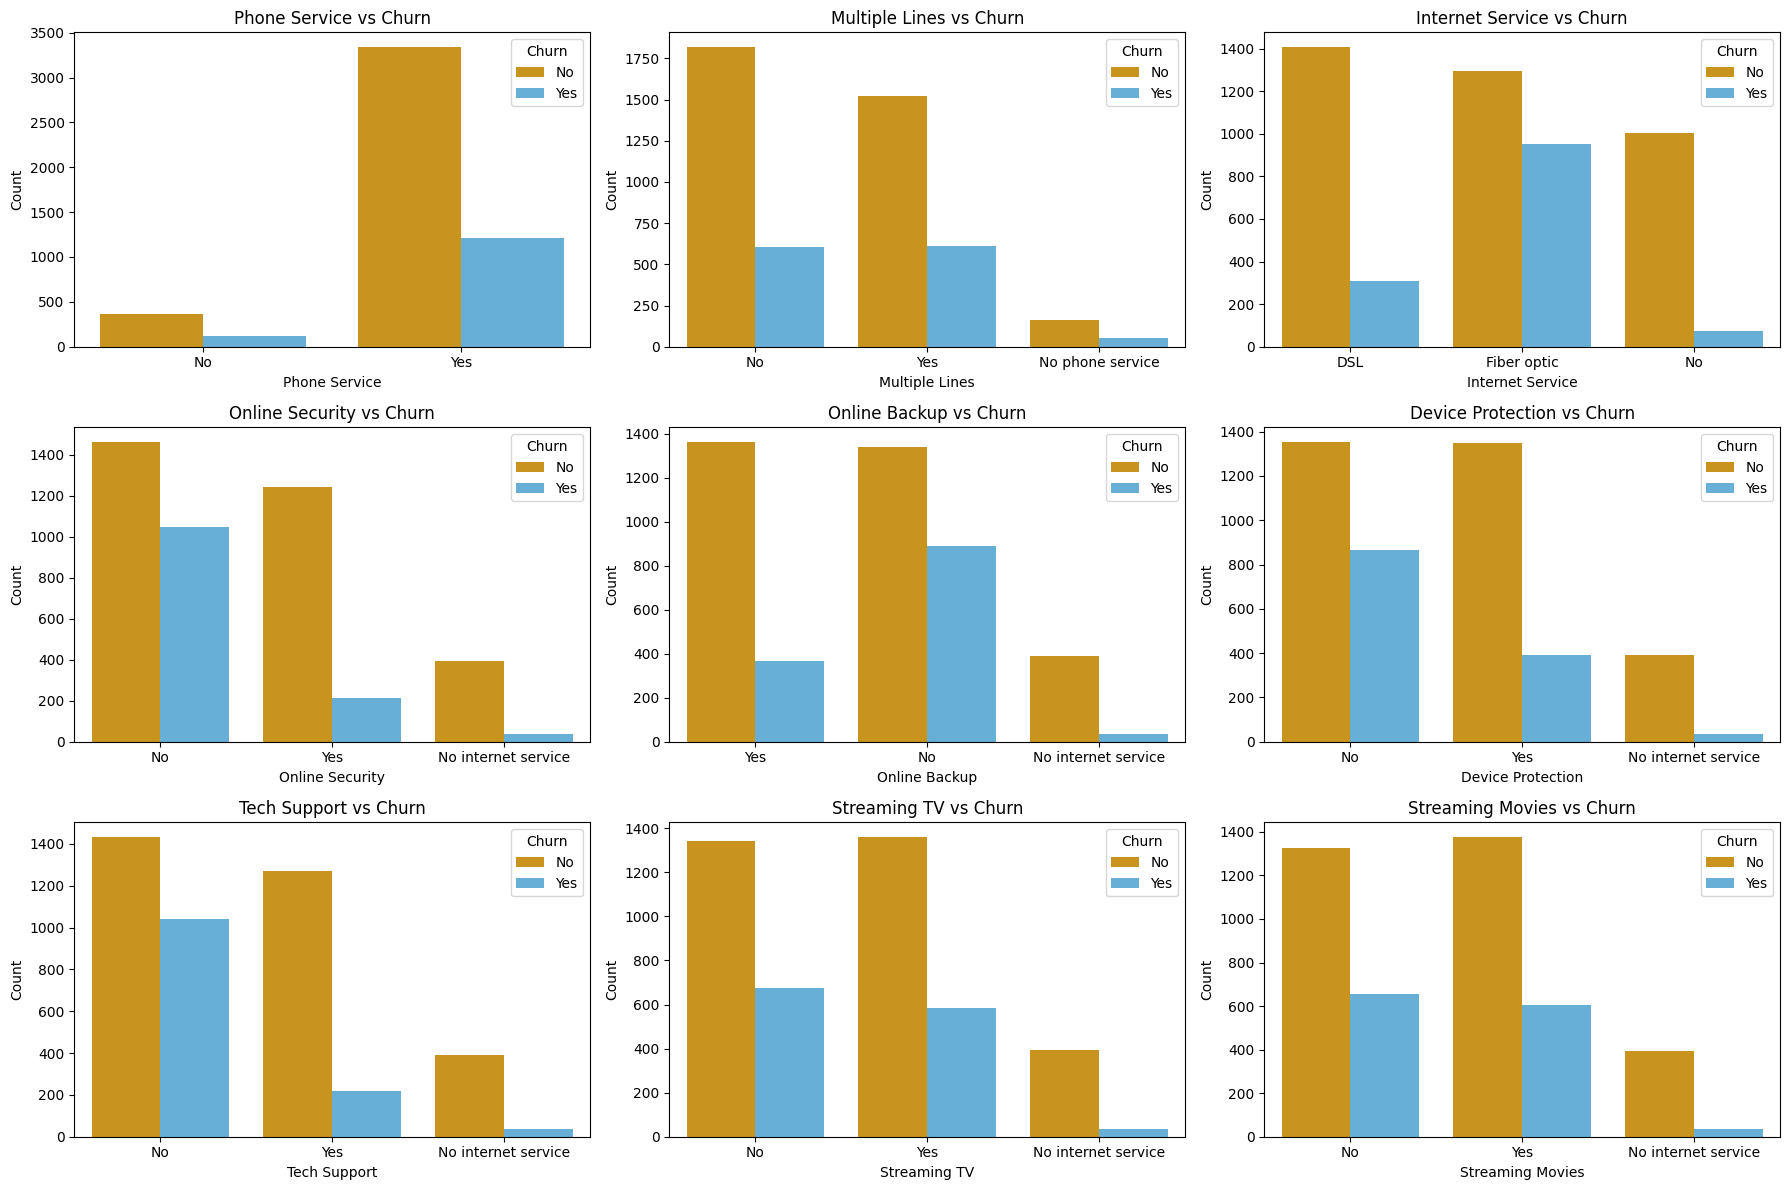

In [32]:

# Set a colorblind-friendly palette
color_palette = ['#E69F00', '#56B4E9']

# Create a big canvas to hold all the small plots
plt.figure(figsize=(18, 12))

# First plot: Phone Service
plt.subplot(3, 3, 1)  # 3 rows, 3 columns, 1st position
sns.countplot(data=combined_eda, x='PhoneService', hue='Churn', palette=color_palette)
plt.title('Phone Service vs Churn')
plt.xlabel('Phone Service')
plt.ylabel('Count')

# Second plot: Multiple Lines
plt.subplot(3, 3, 2)  # 2nd position
sns.countplot(data=combined_eda, x='MultipleLines', hue='Churn', palette=color_palette)
plt.title('Multiple Lines vs Churn')
plt.xlabel('Multiple Lines')
plt.ylabel('Count')

# Third plot: Internet Service
plt.subplot(3, 3, 3)  # 3rd position
sns.countplot(data=combined_eda, x='InternetService', hue='Churn', palette=color_palette)
plt.title('Internet Service vs Churn')
plt.xlabel('Internet Service')
plt.ylabel('Count')

# Fourth plot: Online Security
plt.subplot(3, 3, 4)  # 4th position
sns.countplot(data=combined_eda, x='OnlineSecurity', hue='Churn', palette=color_palette)
plt.title('Online Security vs Churn')
plt.xlabel('Online Security')
plt.ylabel('Count')

# Fifth plot: Online Backup
plt.subplot(3, 3, 5)  # 5th position
sns.countplot(data=combined_eda, x='OnlineBackup', hue='Churn', palette=color_palette)
plt.title('Online Backup vs Churn')
plt.xlabel('Online Backup')
plt.ylabel('Count')

# Sixth plot: Device Protection
plt.subplot(3, 3, 6)  # 6th position
sns.countplot(data=combined_eda, x='DeviceProtection', hue='Churn', palette=color_palette)
plt.title('Device Protection vs Churn')
plt.xlabel('Device Protection')
plt.ylabel('Count')

# Seventh plot: Tech Support
plt.subplot(3, 3, 7)  # 7th position
sns.countplot(data=combined_eda, x='TechSupport', hue='Churn', palette=color_palette)
plt.title('Tech Support vs Churn')
plt.xlabel('Tech Support')
plt.ylabel('Count')

# Eighth plot: Streaming TV
plt.subplot(3, 3, 8)  # 8th position
sns.countplot(data=combined_eda, x='StreamingTV', hue='Churn', palette=color_palette)
plt.title('Streaming TV vs Churn')
plt.xlabel('Streaming TV')
plt.ylabel('Count')

# Ninth plot: Streaming Movies
plt.subplot(3, 3, 9)  # 9th position
sns.countplot(data=combined_eda, x='StreamingMovies', hue='Churn', palette=color_palette)
plt.title('Streaming Movies vs Churn')
plt.xlabel('Streaming Movies')
plt.ylabel('Count')

# Make sure everything fits nicely
plt.tight_layout()

plt.show()


- Customers with no internet service are less likely to churn, indicating that internet service type is a significant factor
- Lack of online security correlates positively with churn, suggesting that customers without this service might be more prone to leaving
- MultipleLines could be related to whether the customer has a phone service plan or the type of phone service they have
- This links directly to why those with phone service are likely to churn
- Both steaming services, that is, Tv and Movies, seemto have moderately the same impact when it comes to churn  and unchurn count

3. Can payment methods affect customer retention?

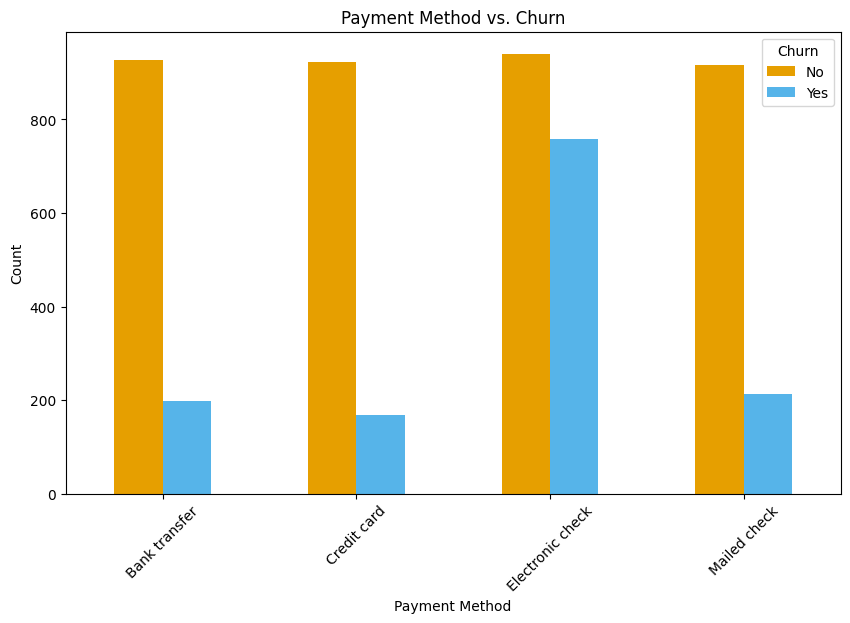

In [34]:
# Stacked bar plot

color_palette = ['#E69F00', '#56B4E9']

# Create a stacked bar plot for Payment Method vs. Churn

payment_churn = combined_eda.groupby(['PaymentMethod', 'Churn']).size().unstack()
payment_churn.plot(kind='bar', stacked=False, figsize=(10, 6), color=color_palette)

# Customize the plot
plt.title('Payment Method vs. Churn')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.grid(False)
plt.legend(title='Churn')
plt.xticks(rotation=45)
plt.show()



- Payment method does seem to have an impact on churn with electronic check having the highest churn count in comparison with the rest of the payment methods meaning those that use the electronic check payment method are more likely to churn

4. Is there a correlation between tenure and churn ?

In [35]:
# Check for maximum tenure 
combined_eda['tenure'].max()

72

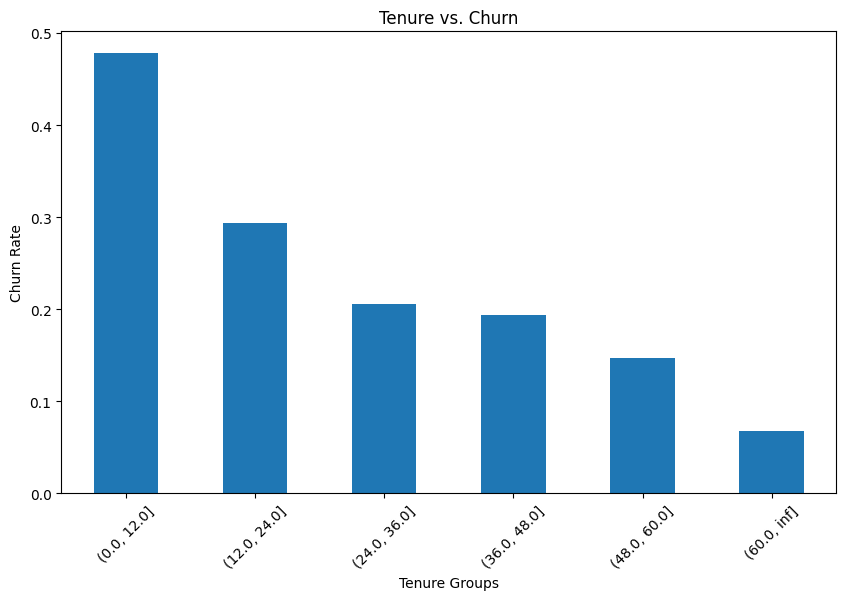

In [36]:
# Calculate churn for different tenure groups
tenure_groups = combined_eda.groupby(pd.cut(combined_eda['tenure'], bins=[0, 12, 24, 36, 48, 60, float('inf')]))
churn_rate = tenure_groups['Churn'].value_counts(normalize=True).unstack()['Yes']

# Plot the churn rate
plt.figure(figsize=(10, 6))
churn_rate.plot(kind='bar')
plt.title('Tenure vs. Churn')
plt.xlabel('Tenure Groups')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

- As tenure length increases, churn rate decreases suggesing that customers with longer tenures are less likely to leave as compared to customers with less tenures, that is, the relatively new customers

5. Does the type of contract influence customer churn?

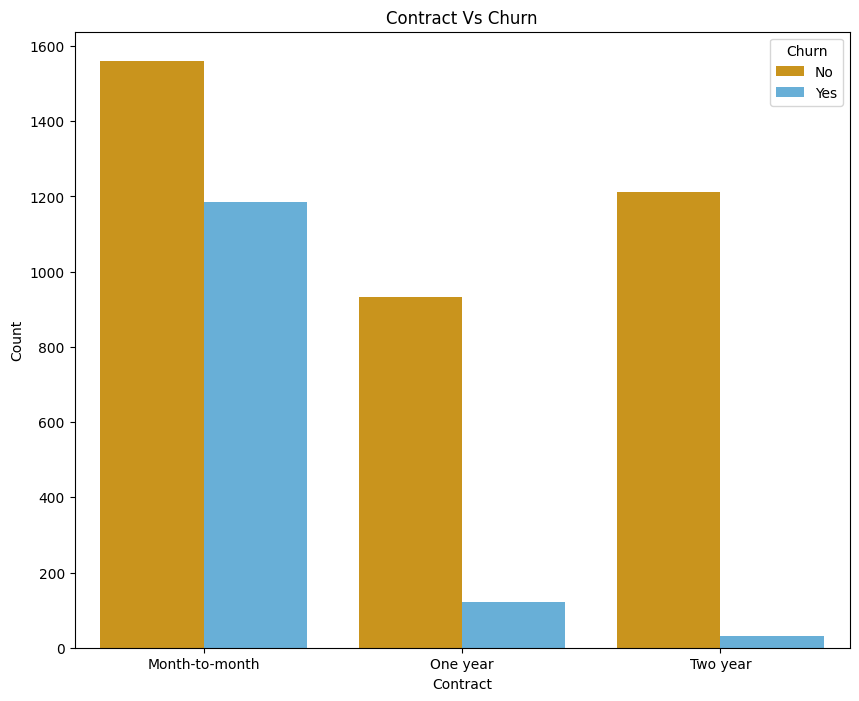

In [37]:

color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(10, 8))
sns.countplot(x='Contract', hue='Churn', data=combined_eda, palette=color_palette)
plt.title('Contract Vs Churn')
plt.xlabel('Contract')
plt.ylabel('Count')
plt.show()

Similar to tenure, as contract length increases, churn rate decreases indicating that short term contract customers have an extremely high likelihood of churning compared to long term contact customers


####        Hypothesis

Test Hypothesis

For hypothesis testing, we'll look at a couple of attributes to determine if we should reject our hypothesis or fail to reject it.

In [38]:
# Checking data types
print(combined_eda.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [39]:

from scipy.stats import chi2_contingency

# Create a contingency table

contingency_table = pd.crosstab(combined_eda['PaymentMethod'], combined_data['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant association between paymment method and churn ")
else:
    print("Fail to reject the null hypothesis: There is no significant association between payment method and churn ")

Contingency Table:
Churn             False   No  True  Yes
PaymentMethod                          
Bank transfer       565  362   122   76
Credit card         566  356    91   77
Electronic check    553  388   450  308
Mailed check        535  381   117   95
Chi-Square Statistic: 440.3860817228332
P-value: 3.254409983782546e-89
Reject the null hypothesis: There is a significant association between paymment method and churn 


In [40]:
# To find out which other features significantly influence Churn

# Identify categorical features
categorical_features = combined_eda.select_dtypes(include=['object']).columns

# Initialize a list to store features that affect churn
significant_features_chi2 = []

# Initialize a dictionary to store p-values of all features
feature_p_values = {}

# Loop through each categorical feature
for feature in categorical_features:
    if feature != 'Churn':
        
        contingency_table = pd.crosstab(combined_eda[feature], combined_eda['Churn'])
        
        
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Store the p-value in the dictionary
        feature_p_values[feature] = p_val
        
        if p_val < 0.05:
            significant_features_chi2.append(feature)

# Print the p-values for all features
print("P-values for all features:")
for feature, p_val in feature_p_values.items():
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Feature: {feature}, p-value: {p_val:.6f} ({significance})")

# Print the list of significant features
print("\nSignificant features affecting churn:")
print(significant_features_chi2)

P-values for all features:
Feature: customerID, p-value: 0.493379 (Not Significant)
Feature: gender, p-value: 0.883080 (Not Significant)
Feature: Partner, p-value: 0.000000 (Significant)
Feature: Dependents, p-value: 0.000000 (Significant)
Feature: PhoneService, p-value: 0.327932 (Not Significant)
Feature: MultipleLines, p-value: 0.021482 (Significant)
Feature: InternetService, p-value: 0.000000 (Significant)
Feature: OnlineSecurity, p-value: 0.000000 (Significant)
Feature: OnlineBackup, p-value: 0.000000 (Significant)
Feature: DeviceProtection, p-value: 0.000000 (Significant)
Feature: TechSupport, p-value: 0.000000 (Significant)
Feature: StreamingTV, p-value: 0.000000 (Significant)
Feature: StreamingMovies, p-value: 0.000000 (Significant)
Feature: Contract, p-value: 0.000000 (Significant)
Feature: PaperlessBilling, p-value: 0.000000 (Significant)
Feature: PaymentMethod, p-value: 0.000000 (Significant)

Significant features affecting churn:
['Partner', 'Dependents', 'MultipleLines', 'I

Contract Interpretation:
The low p-value suggests a strong relationship between the type of contract and churn. Customers on different contract terms (month-to-month, one year, two years) have significantly different churn rates. Month-to-month contracts, for example, might be more likely to churn compared to longer-term contracts.

Gender Interpretation:
The high p-value indicates that gender does not significantly affect churn rates. In other words, male and female customers churn at similar rates, and gender is not a significant predictor of whether a customer will churn.

Tenure Interpretation:
The very low p-value suggests a strong relationship between tenure and churn. Customers with different tenures have significantly different churn rates. Typically, customers with shorter tenures are more likely to churn compared to those who have been with the company for a longer period.

Total Charges Interpretation:
The p-value is greater than 0.05, suggesting that there is no significant relationship between total charges and churn.Therefore, total charges do not significantly influence churn rates.

Payment Method Interpretation:
The p-value is very small, indicating a highly significant relationship between payment method and churn. Different payment methods have significantly different churn rates.


Null Hypothesis (H0): 
There is no significant relationship between customer attributes (demographics, usage patterns, etc.) and churn.
    Alternative Hypothesis (H1): 
Specific customer attributes significantly influence churn rates.

With the p levels of different attributes, we thereby reject the null hypothesist that There is no significant relationship between customer attributes and churn rate

At a significance level of 5%, there is enough evidence to conclude that different attributes such as demographs, contract types, payment methods etc do affect the churn rates


## Data Preparation

###    a. Separating The Data

#### Overview Of Columns

In [41]:
combined_model = combined_eda.copy()

In [42]:
combined_model.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [43]:
combined_model.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4863
Churn                  2
dtype: int64

In [44]:
combined_model.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [45]:
# Modify Data Types

combined_model['SeniorCitizen'] = combined_model['SeniorCitizen'].map({0: 'No', 1 :'Yes'})

# Identify object columns to convert to category datatype
columns_to_convert = [col for col in combined_model.select_dtypes(include=['object']).columns]

# Convert object columns to category datatype
combined_model[columns_to_convert] = combined_model[columns_to_convert].astype('category')

combined_model.dtypes

customerID          category
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

#### Drop Irrelevant Columns

In [46]:
combined_model.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [47]:
# Customer ID will be irrelevant when it comes to modelling

combined_model.drop(columns=['customerID'], inplace=True)

In [48]:
combined_model.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [49]:
combined_model['Churn'].value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

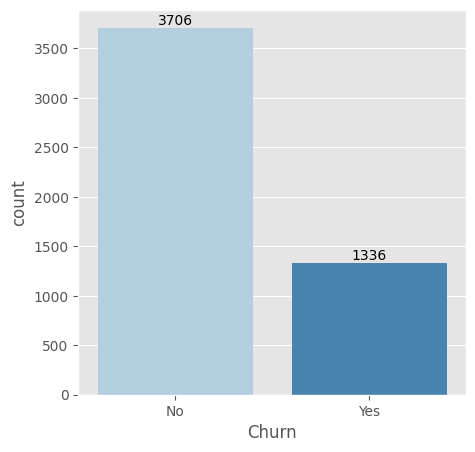

In [50]:
#Apply the ggplot style

plt.style.use("ggplot")

plt.figure(figsize=(5,5))
ax = sns.countplot(x = combined_model["Churn"],palette="Blues")
for container in ax.containers:
    ax.bar_label(container)
plt.show()


This is an unbalanced data since the churned count is roughly more than twice of the unchurned hence there's a need for upsampling the data

In [51]:
df_majority = combined_model[combined_model['Churn'] == 'No']
df_minority = combined_model[combined_model['Churn'] == 'Yes']

df_minority_upsampled = resample(df_minority,
                                 replace=True,               # sample with replacement
                                 n_samples=len(df_majority), # same length as majority class
                                 random_state=42)            # for reproducibility

combined_model_df = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
combined_model_df['Churn'].value_counts()

Churn
No     3706
Yes    3706
Name: count, dtype: int64

####    Separate features (X) and target variable (y)

In [52]:
combined_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 2494
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7412 non-null   category
 1   SeniorCitizen     7412 non-null   category
 2   Partner           7412 non-null   category
 3   Dependents        7412 non-null   category
 4   tenure            7412 non-null   int64   
 5   PhoneService      7412 non-null   category
 6   MultipleLines     7041 non-null   category
 7   InternetService   7412 non-null   category
 8   OnlineSecurity    6692 non-null   category
 9   OnlineBackup      6692 non-null   category
 10  DeviceProtection  6692 non-null   category
 11  TechSupport       6692 non-null   category
 12  StreamingTV       6692 non-null   category
 13  StreamingMovies   6692 non-null   category
 14  Contract          7412 non-null   category
 15  PaperlessBilling  7412 non-null   category
 16  PaymentMethod     7412 non-nu

In [53]:
X = combined_model_df.drop(['Churn'], axis=1)
y = combined_model_df['Churn']

In [54]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [55]:
y.unique()

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

In [56]:
y.value_counts()

Churn
No     3706
Yes    3706
Name: count, dtype: int64

####    Split Dataset into Categorical and Numerical Columns

In [57]:
# Numerical

numeric_features = X.select_dtypes('number').columns
numeric_features

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [58]:
# Categorical

categorical_features = X.select_dtypes('category').columns
categorical_features

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 2494
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7412 non-null   category
 1   SeniorCitizen     7412 non-null   category
 2   Partner           7412 non-null   category
 3   Dependents        7412 non-null   category
 4   tenure            7412 non-null   int64   
 5   PhoneService      7412 non-null   category
 6   MultipleLines     7041 non-null   category
 7   InternetService   7412 non-null   category
 8   OnlineSecurity    6692 non-null   category
 9   OnlineBackup      6692 non-null   category
 10  DeviceProtection  6692 non-null   category
 11  TechSupport       6692 non-null   category
 12  StreamingTV       6692 non-null   category
 13  StreamingMovies   6692 non-null   category
 14  Contract          7412 non-null   category
 15  PaperlessBilling  7412 non-null   category
 16  PaymentMethod     7412 non-nu

###    Feature Engineering

####        Handling Missing Values

### Using manual method

In [60]:
X.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2054
TotalCharges        4761
dtype: int64

In [61]:
# 1. Handling missing values for service-related features 

# Check if customer has no internet service and fill related columns with 'No'

service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

# Fill 'No' where InternetService is 'No'

for col in service_columns:
    combined_model_df.loc[combined_model_df['InternetService'] == 'No', col] = 'No'

# If PhoneService is 'No', MultipleLines should be 'No'

combined_model_df.loc[combined_model_df['PhoneService'] == 'No', 'MultipleLines'] = 'No'


In [62]:
# 2. Handling missing TotalCharges

# Fill missing TotalCharges with 0 where tenure is 0

combined_model_df['TotalCharges'] = pd.to_numeric(combined_model_df['TotalCharges'], errors='coerce')

combined_model_df.loc[combined_model_df['tenure'] == 0, 'TotalCharges'] = 0

# Fill any remaining missing TotalCharges with median value

combined_model_df['TotalCharges'].fillna(combined_model_df['TotalCharges'].median(), inplace=True)


In [63]:
# 3. Handling missing Churn

# Fill missing Churn with the most frequent value

combined_model_df['Churn'].fillna(combined_model_df['Churn'].mode()[0], inplace=True)


In [64]:
combined_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 2494
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7412 non-null   category
 1   SeniorCitizen     7412 non-null   category
 2   Partner           7412 non-null   category
 3   Dependents        7412 non-null   category
 4   tenure            7412 non-null   int64   
 5   PhoneService      7412 non-null   category
 6   MultipleLines     7412 non-null   category
 7   InternetService   7412 non-null   category
 8   OnlineSecurity    7412 non-null   category
 9   OnlineBackup      7412 non-null   category
 10  DeviceProtection  7412 non-null   category
 11  TechSupport       7412 non-null   category
 12  StreamingTV       7412 non-null   category
 13  StreamingMovies   7412 non-null   category
 14  Contract          7412 non-null   category
 15  PaperlessBilling  7412 non-null   category
 16  PaymentMethod     7412 non-nu

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 2494
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7412 non-null   category
 1   SeniorCitizen     7412 non-null   category
 2   Partner           7412 non-null   category
 3   Dependents        7412 non-null   category
 4   tenure            7412 non-null   int64   
 5   PhoneService      7412 non-null   category
 6   MultipleLines     7041 non-null   category
 7   InternetService   7412 non-null   category
 8   OnlineSecurity    6692 non-null   category
 9   OnlineBackup      6692 non-null   category
 10  DeviceProtection  6692 non-null   category
 11  TechSupport       6692 non-null   category
 12  StreamingTV       6692 non-null   category
 13  StreamingMovies   6692 non-null   category
 14  Contract          7412 non-null   category
 15  PaperlessBilling  7412 non-null   category
 16  PaymentMethod     7412 non-nu

In [66]:
y.info()

<class 'pandas.core.series.Series'>
Index: 7412 entries, 0 to 2494
Series name: Churn
Non-Null Count  Dtype   
--------------  -----   
7412 non-null   category
dtypes: category(1)
memory usage: 65.3 KB


In [67]:
# Display all rows with any NaN values
print(combined_model_df[combined_model_df.isnull().any(axis=1)])


Empty DataFrame
Columns: [gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


Service Features
 For each column related to services, check if InternetService is 'No' and fill in the respective service columns with 'No'. Similarly, if PhoneService is 'No', we set MultipleLines to 'No'.

TotalCharges
 Convert TotalCharges to numeric to handle any non-numeric values. For customers with tenure equal to 0, we assume they have not been charged yet and set TotalCharges to 0. Fill any remaining missing values with the median of TotalCharges.

Churn
 We fill the missing Churn value with the mode (most frequent value). This is usually either 'Yes' or 'No'.

Manual method doesn't seem to work

####        Handling missing values using simple imputer

In [68]:
# Define numerical and categorical columns

numeric_features = X.select_dtypes('number').columns
categorical_features = X.select_dtypes('category').columns

# Impute missing values for numerical columns

num_imputer = SimpleImputer(strategy='median')
combined_model_df[numeric_features] = num_imputer.fit_transform(combined_model_df[numeric_features])

# Impute missing values for categorical columns

cat_imputer = SimpleImputer(strategy='most_frequent')
combined_model_df[categorical_features] = cat_imputer.fit_transform(combined_model_df[categorical_features])


In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 2494
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7412 non-null   category
 1   SeniorCitizen     7412 non-null   category
 2   Partner           7412 non-null   category
 3   Dependents        7412 non-null   category
 4   tenure            7412 non-null   int64   
 5   PhoneService      7412 non-null   category
 6   MultipleLines     7041 non-null   category
 7   InternetService   7412 non-null   category
 8   OnlineSecurity    6692 non-null   category
 9   OnlineBackup      6692 non-null   category
 10  DeviceProtection  6692 non-null   category
 11  TechSupport       6692 non-null   category
 12  StreamingTV       6692 non-null   category
 13  StreamingMovies   6692 non-null   category
 14  Contract          7412 non-null   category
 15  PaperlessBilling  7412 non-null   category
 16  PaymentMethod     7412 non-nu

Simple imputer doesn't seem to work either

####    Split Dataset into Training and Evaluation

In [70]:
print(combined_model_df[combined_model_df.isnull().any(axis=1)])

Empty DataFrame
Columns: [gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [72]:
# Display the shapes of the resulting splits

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5559, 19)
X_test shape: (1853, 19)
y_train shape: (5559,)
y_test shape: (1853,)


####        Scale or normalize numeric features

In [73]:

# Create the scaler for numerical features

scaler = RobustScaler()

# Fit and transform numerical features

X_numeric = combined_model_df[numeric_features]
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Convert the scaled data back to a DataFrame for easier handling

X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features)

X_numeric_scaled_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-0.477273,-0.989526,-0.375078
1,0.272727,-0.391951,0.232380
2,0.522727,-0.714994,0.216456
3,0.000000,0.316979,0.251947
4,-0.272727,-0.991731,-0.286212


####        Perform transformations for skewed data

In [74]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7412.0,27.968025,24.056649,0.000000,5.000000,22.000,49.000000,72.000000
MonthlyCharges,7412.0,68.394974,28.790129,18.400000,45.700001,74.725,91.050003,118.650002
TotalCharges,7404.0,2071.184172,2198.904431,18.799999,281.000000,1178.250,3342.624939,8670.100000


In [75]:
# Check for skewness to determine the scaler to use

X.select_dtypes('number').skew()

tenure            0.488137
MonthlyCharges   -0.414663
TotalCharges      1.094680
dtype: float64

In [76]:
# Loop through each numerical column in the lis

for col in numeric_features:
    # Calculate skewness and kurtosis
    skewness = round(X[col].skew(), 2)
    kurtosis = round(X[col].kurtosis(), 2)

    # Print column name and its statistics
    print(f"Column: {col}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print("-" * 40)
  

Column: tenure
Skewness: 0.49
Kurtosis: -1.19
----------------------------------------
Column: MonthlyCharges
Skewness: -0.41
Kurtosis: -1.05
----------------------------------------
Column: TotalCharges
Skewness: 1.09
Kurtosis: 0.08
----------------------------------------


####        Encode input features

In [77]:
# Check for NaNs in categorical features

nan_counts = combined_model_df[categorical_features].isna().sum()
nan_counts


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
dtype: int64

In [89]:
'''
# Create the encoder for categorical features

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical features

X_categorical = combined_model_df[categorical_features]
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Convert the encoded data back to a DataFrame
# Column names are generated by combining feature name and category
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names)

X_categorical_encoded_df.head()
'''

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


####        Encode output features

In [78]:
print(y_train.isna().sum())
print(y_test.isna().sum())

0
0


In [79]:
encoder = LabelEncoder()

y_train= encoder.fit_transform(y_train)
y_test= encoder.transform(y_test)

###        Combining everything into a pipeline

In [81]:

# Create a pipeline for numeric features

numeric_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', RobustScaler()),
    ('power-transformation', PowerTransformer (method='yeo-johnson'))
])

# Create a pipeline for categorical features

categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)
])

# Combine the two pipelines

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])



In [82]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler()),
                                                 ('power-transformation',
                                                  PowerTransformer())]),
                                 Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])


## 4. Modeling

####    a. Fit Data to the Pipeline and Train Model
    
Train multiple models:Logistic Regression, Decision Tree Classifier, Random Forest, Support Vector Machine

In [83]:

# from sklearn.metrics import classification_report

# Initialize models

models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

In [93]:
'''
# Define oversampling technique
over_sampler = SMOTE(random_state=42)

pipelines = []

for model_name, classifier in models:
    # Create the pipeline for each model
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('ovr', over_sampler),
        ('model', classifier)
    ])
    pipelines.append((model_name, pipeline))
'''

"\n# Define oversampling technique\nover_sampler = SMOTE(random_state=42)\n\npipelines = []\n\nfor model_name, classifier in models:\n    # Create the pipeline for each model\n    pipeline = ImbPipeline(steps=[\n        ('preprocessor', preprocessor),\n        ('ovr', over_sampler),\n        ('model', classifier)\n    ])\n    pipelines.append((model_name, pipeline))\n"

In [84]:
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f'Model: {model_name}')
    print(classification_report(y_test, y_pred))
    print('=' * 50)

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       927
           1       0.81      0.94      0.87       926

    accuracy                           0.86      1853
   macro avg       0.87      0.86      0.86      1853
weighted avg       0.87      0.86      0.86      1853

Model: SVC
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       927
           1       0.75      0.85      0.80       926

    accuracy                           0.78      1853
   macro avg       0.79      0.78      0.78      1853
weighted avg       0.79      0.78      0.78      1853

Model: Random Forest
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       927
           1       0.84      0.95      0.89       926

    accuracy                           0.89      1853
   macro avg       0.89      0.89      0.89      1853
weighted avg       0.

Decision Tree
    -The precision and recall for class 1 (churn) are relatively low, indicating that the Decision Tree model struggles with identifying churn cases.
    -The model has a higher performance for class 0 (non-churn), with better precision, recall, and F1-score.
    -The overall accuracy is 72%

Support Vector Machine (SVC)
    -SVC performs better than the Decision Tree, with an accuracy of 79%.
    -It shows a good balance between precision and recall for class 1 (churn), though recall is slightly lower.
    -The F1-score for class 1 is higher than that of the Decision Tree, indicating better overall performance in identifying churn.

Random Forest
    -Random Forest has a comparable accuracy to SVC (79%).
    -The F1-score for class 1 (churn) is similar to that of SVC, indicating decent performance in identifying churn cases.
    -Random Forest's precision for class 1 is slightly lower than that of SVC, but recall is similar.

Logistic Regression
    -Logistic Regression also achieves an accuracy of 79%, similar to SVC and Random Forest.
    -The precision and recall for class 1 are comparable to those of Random Forest and SVC.

## Evaluation

####    a.Advanced Model Evaluation and Visualizing Model Performance

1. Confusion Matrix

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = pipeline.predict(X_test)

# Our pipeline is our trained model, X_test is our test features and y_test_encoded is encoded labels

In [86]:
# Create a confusion matrix function

cm = confusion_matrix(y_test, y_pred)

# Compares the actual target values (y_test_encoded) with the predicted values (y_pred).

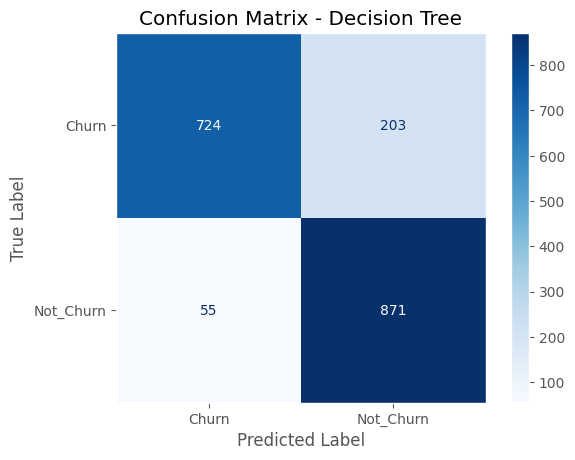

<Figure size 640x480 with 0 Axes>

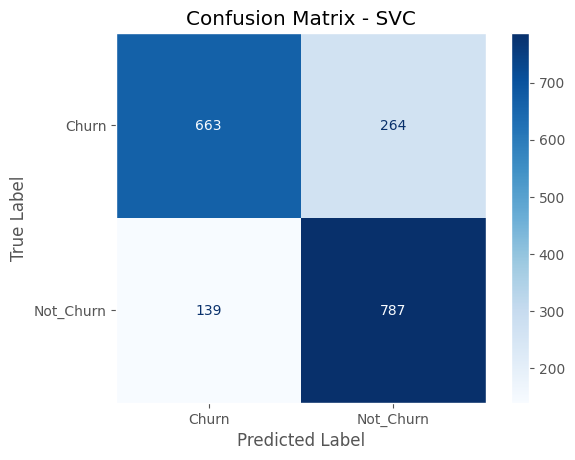

<Figure size 640x480 with 0 Axes>

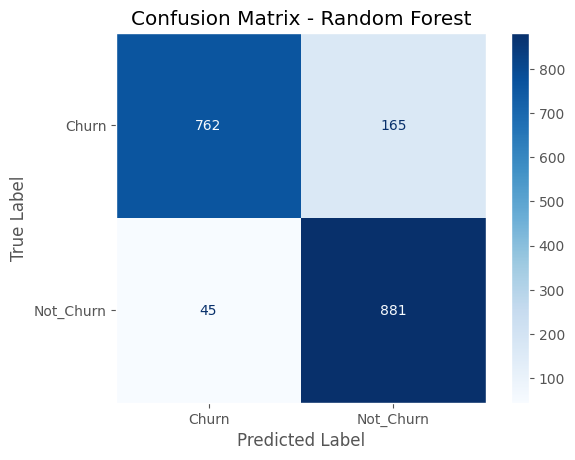

<Figure size 640x480 with 0 Axes>

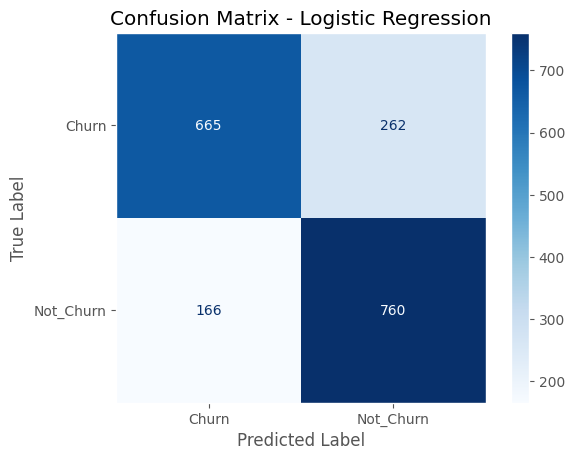

<Figure size 640x480 with 0 Axes>

In [99]:
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'Not_Churn'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)
    plt.show()
    plt.tight_layout()

2. ROC Curve and AUC Score

In [88]:

# Generate Prediction Probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]


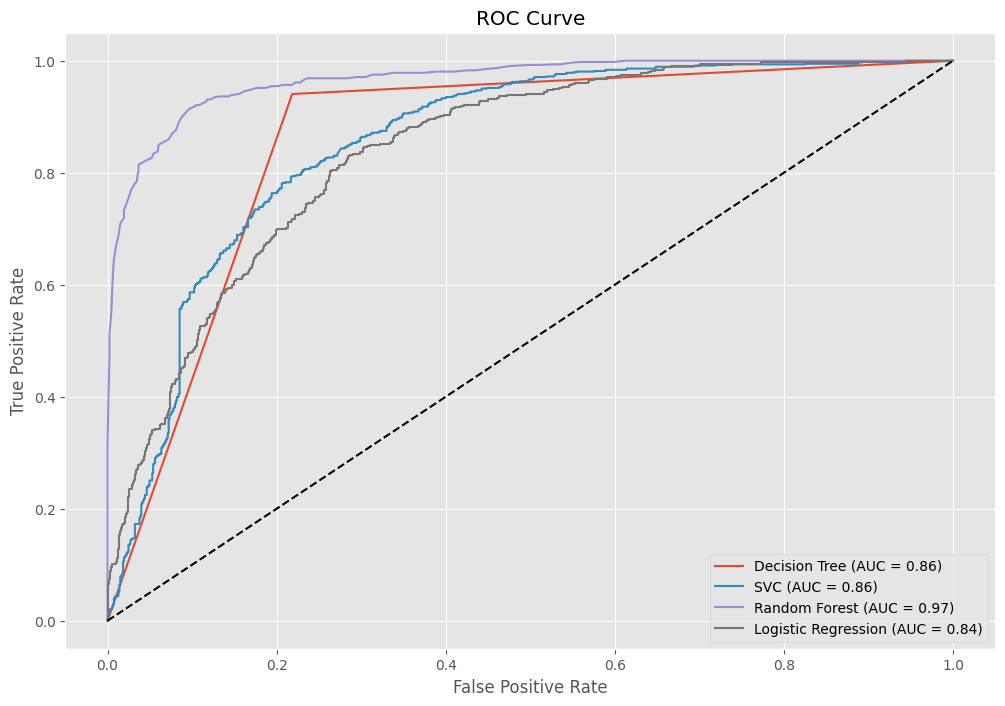

In [89]:
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(models, X_test, y_test)

Understanding AUC Scores

AUC (Area Under the Curve): The AUC score represents the area under the ROC curve, which plots the true positive rate (recall) against the false positive rate. The AUC score ranges from 0 to 1, where:
0.5 represents a model with no discriminative ability (equivalent to random guessing).
1.0 represents a perfect model.
AUC close to 1 indicates excellent model performance.
AUC less than 0.5 indicates a poor model.

Decision Tree (AUC = 0.66):
    - This is a relatively low AUC, suggesting that the decision tree model has limited ability to distinguish between the classes (churn vs. non-churn)

Support Vector Machine (SVC) (AUC = 0.81):

    - A solid AUC score, indicating that the SVC model has a good ability to discriminate between churners and non-churners. It suggests a well-performing model.

Random Forest (AUC = 0.81):

    - Similar to SVC, the Random Forest model also shows good performance with an AUC of 0.81. This suggests that the ensemble method is effectively capturing the relationship between the features and the churn outcome.

Logistic Regression (AUC = 0.84):

    -Logistic regression appears to be the best performer in this case, indicating strong discriminative power for identifying churners.

3. Precision-Recall Curve

In [90]:

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class

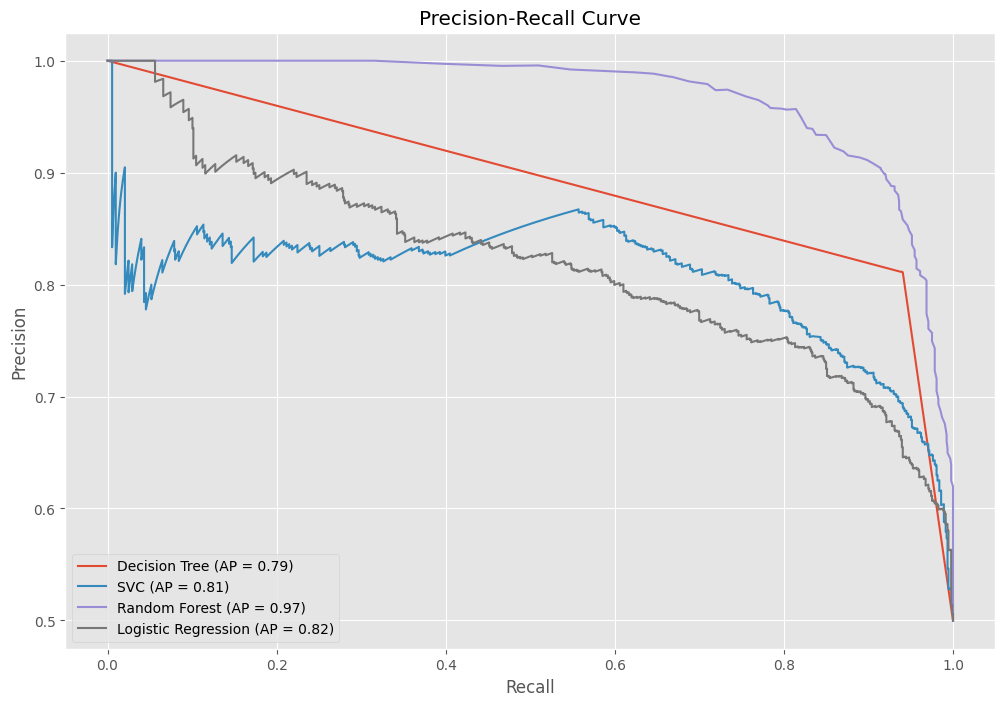

In [91]:


def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

plot_precision_recall_curve(models, X_test, y_test)


Understanding AP Scores

Average Precision (AP): This score summarizes the precision-recall curve by computing the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. The AP score ranges from 0 to 1, where:
0 represents a model that performs as poorly as possible (precision is zero at all recall levels).
1 represents a perfect model (high precision for every recall level).
Higher AP indicates better performance in distinguishing between positive (churn) and negative (non-churn) classes, particularly in scenarios with class imbalance.

Decision Tree (AP = 0.79):

    - This is the lowest AP score among the models. It suggests that the Decision Tree model has limited ability to maintain high precision across different recall levels. It might produce many false positives, especially at higher recall levels.

Support Vector Machine (SVC) (AP = 0.81):

    - This score indicates a fairly good performance. The SVC model maintains a decent balance between precision and recall, suggesting it handles class imbalance reasonably well.

Random Forest (AP = 0.97):

    - The highest AP score among the models. It is the most effective model in terms of handling class imbalance and reducing false positives.

Logistic Regression (AP = 0.82):

    - Similar to SVC, the Random Forest model shows good performance with an AP score of 0.62. This indicates that it can effectively maintain precision while identifying true positives (churners).


####    b. Feature Importance and Selection

In [103]:
'''
# Train a Logistic Regression model

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train_encoded)

# Get coefficients and feature names

coefficients = log_reg_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame for better visualization

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()

# Sort by importance

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importances

print(feature_importance_df[['Feature', 'Coefficient', 'Importance']])
'''

"\n# Train a Logistic Regression model\n\nlog_reg_model = LogisticRegression(random_state=42, max_iter=1000)\nlog_reg_model.fit(X_train, y_train_encoded)\n\n# Get coefficients and feature names\n\ncoefficients = log_reg_model.coef_[0]\nfeature_names = X_train.columns\n\n# Create a DataFrame for better visualization\n\nfeature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})\nfeature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()\n\n# Sort by importance\n\nfeature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)\n\n# Print or visualize feature importances\n\nprint(feature_importance_df[['Feature', 'Coefficient', 'Importance']])\n"

####    c. Hyperparameter Tuning

In [107]:

# Define hyperparameter grids
'''
param_grid_dt = {'max_depth': [3, 5, 10, None],
                 'min_samples_split': [2, 5, 10]}

param_grid_svc = {'C': [0.1, 1, 10, 100],
                  'gamma': [1, 0.1, 0.01, 0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid']}

param_grid_rf = {'n_estimators': [100, 200, 500],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [4, 6, 8, 10, None]}

param_grid_lr = {'C': [0.1, 1, 10, 100],
                 'penalty': ['l1', 'l2']}
'''

In [112]:
'''
# Define parameter grid for GridSearchCV

param_grid_dt= {'max_depth': [None, 10, 20,30],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8]}

param_grid_lr= {'C': [0.1, 1.0, 10.0],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

param_grid_rf= {'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}

param_grid_svc= {'C': [0.1, 1.0, 10.0],
                'gamma': ['scale', 'auto'],
                'kernel': ['rbf', 'linear', 'poly']}
'''

In [ ]:
'''
# Running Grid Search

# Decision Tree

grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5, scoring='accuracy', error_score='raise')
grid_search_dt.fit(X_train, y_train)

# SVC

grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid_svc, cv=5, scoring='accuracy', error_score='raise')
grid_search_svc.fit(X_train, y_train)

# Random Forest

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', error_score='raise')
grid_search_rf.fit(X_train, y_train)

# Logistic Regression

grid_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, cv=5, scoring='accuracy', error_score='raise')
grid_search_lr.fit(X_train, y_train)
'''

In [92]:
param_grid_dt = {
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8]
}

param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

param_grid_svc = {
    'model__C': [0.1, 1.0, 10.0],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf', 'linear', 'poly']
}

In [93]:
def run_grid_search(model_name, model, param_grid):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_


In [118]:
'''

# Running GridSearchCV for each model
results = {}
for name, model in models:
    if name == 'Decision Tree':
        results[name] = run_grid_search(name, model, param_grid_dt)
    elif name == 'SVC':
        results[name] = run_grid_search(name, model, param_grid_svc)
    elif name == 'Random Forest':
        results[name] = run_grid_search(name, model, param_grid_rf)
    elif name == 'Logistic Regression':
        results[name] = run_grid_search(name, model, param_grid_lr)

print(results)
'''

{'Decision Tree': ({'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}, 0.8523107706454098), 'SVC': ({'model__C': 10.0, 'model__gamma': 'scale', 'model__kernel': 'rbf'}, 0.8278474250302729), 'Random Forest': ({'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}, 0.8832541167785843)}


In [94]:

# Running GridSearchCV for each model
results = {}
for name, model in models:
    if name == 'Decision Tree':
        results[name] = run_grid_search(name, model, param_grid_dt)
    elif name == 'SVC':
        results[name] = run_grid_search(name, model, param_grid_svc)
    elif name == 'Random Forest':
        results[name] = run_grid_search(name, model, param_grid_rf)
    elif name == 'Logistic Regression':
        results[name] = run_grid_search(name, model, param_grid_lr)

# Convert results to a DataFrame
results_table = pd.DataFrame.from_dict(results, orient='index', columns=['Best Params', 'Best Score'])

print(results_table)

results_table['Best Score'] = results_table['Best Score'].map(lambda x: round(x, 4))  # Rounding scores for rea

                                                           Best Params  \
Decision Tree        {'model__max_depth': 20, 'model__min_samples_l...   
SVC                  {'model__C': 10.0, 'model__gamma': 'scale', 'm...   
Random Forest        {'model__max_depth': None, 'model__min_samples...   
Logistic Regression  {'model__C': 1.0, 'model__penalty': 'l1', 'mod...   

                     Best Score  
Decision Tree            0.8523  
SVC                      0.8278  
Random Forest            0.8833  
Logistic Regression      0.7791  


In [97]:

# Create the final models with the best parameters
best_dt = DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
best_svc = SVC(random_state=42, C=10.0, gamma='scale', kernel='rbf', probability=True)
best_rf = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
best_lr = LogisticRegression(random_state=42, C=10.0, penalty='l2', solver='liblinear')

# Define the pipelines
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_dt)
])

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_svc)
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_rf)
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_lr)
])

# Train and evaluate each model
pipelines = {
    'Decision Tree': pipeline_dt,
    'SVC': pipeline_svc,
    'Random Forest': pipeline_rf,
    'Logistic Regression': pipeline_lr
}

In [98]:
# Dictionary to store evaluation results
evaluation_results = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    cm = confusion_matrix(y_test, y_pred)
    
    evaluation_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

# Print evaluation results
for name, metrics in evaluation_results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")


Model: Decision Tree
Accuracy: 0.8662
Precision: 0.8174
Recall: 0.9428
F1 Score: 0.8756
Confusion Matrix:
[[732 195]
 [ 53 873]]

Model: SVC
Accuracy: 0.8160
Precision: 0.7752
Recall: 0.8898
F1 Score: 0.8286
Confusion Matrix:
[[688 239]
 [102 824]]

Model: Random Forest
Accuracy: 0.8867
Precision: 0.8423
Recall: 0.9514
F1 Score: 0.8935
Confusion Matrix:
[[762 165]
 [ 45 881]]

Model: Logistic Regression
Accuracy: 0.7701
Precision: 0.7437
Recall: 0.8240
F1 Score: 0.7818
Confusion Matrix:
[[664 263]
 [163 763]]



### Key Insights


- Random Forest:

Best Overall Performance: It has the highest accuracy (0.8867), precision (0.8423), recall (0.9514), and F1 score (0.8935).
Confusion Matrix: It has the lowest number of false negatives (45) and a relatively low number of false positives (165).
Conclusion: Random Forest is the best performing model for this dataset.

- Decision Tree:

Second Best Performance: It has good metrics but slightly lower than Random Forest.
Confusion Matrix: It has a higher number of false positives (195) and a similar number of false negatives (53) compared to Random Forest.
Conclusion: Decision Tree is a strong contender but not as good as Random Forest.

- SVC:

Moderate Performance: It has lower accuracy (0.8160) and F1 score (0.8286) compared to Decision Tree and Random Forest.
Confusion Matrix: It has a higher number of false positives (239) and false negatives (102).
Conclusion: SVC performs moderately well but not as good as Decision Tree or Random Forest.

- Logistic Regression:

Lowest Performance: It has the lowest accuracy (0.7701), precision (0.7437), recall (0.8240), and F1 score (0.7818).
Confusion Matrix: It has the highest number of false positives (263) and false negatives (163).
Conclusion: Logistic Regression is the least performing model among the four.

### Recommendations


Model Choice: Based on the evaluation metrics, Random Forest is the best model to use for this dataset.

### Business Implication

- The high recall of the Random Forest model suggests that it is very good at identifying the positive class, which can be crucial depending on the business context. 
- The relatively high precision indicates that it also maintains a good balance by minimizing false positives.